# Importing Dependencies

In [69]:
# Importing Numpy library
import numpy as np

# Importing Pandas library
import pandas as pd

# Importing plotying libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Importing Prophet library
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot

# Importing Scikit-learn libraries
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. Generalized Additive Models (GAMs)

A business time series exhibits trend, seasonality, and holiday effects. It is well characterized by GAMs, which consider a time series to consist of three components: a linear trend, a seasonal effect, and any holiday effect. GAMs were originally invented by Trevor Hastie and Robert Tibshirani in 1986 [1]. The idea of GAMs is intuitive:

- Relationships between the individual predictors and the dependent variable follow smooth patterns that can be linear or nonlinear.
- Additive: these smooth relationships can be estimated simultaneously and then added up.

GAMs have the following components:

$$
Y(t) = T(t) + S(t) + H(t) + \epsilon (t)
$$

- $T(t)$: Trend;
- $S(t)$: Seasonality for weekly, monthly, and yearly seasonality;
- $H(t)$: Holiday Effects for the effects of holidays that occur on potentially irregular schedules over one or more days;
- $\epsilon (t)$ is for any idiosyncratic changes that are not accommodated by the model. This often interpreted as the error term and in most cases it is assumed to follow a normal distribution;

## 1.1. GAMs with Prophet

Prophet is an open-source library for time series by Facebook. Prophet is widely used because it is intuitive, easy to use, and has great visualization tools. Data scientists and engineers who need to build forecasting models quickly will find it very helpful.

The `daily-website-visitors` dataset is about the number of visitors to an academic teaching notes website from Kaggle.com. This dataset has daily counts of page loads, unique visitors, first-time visitors, and returning visitors. The dataset covers the date range from September 14, 2014, to August 19, 2020.

### 1.1.1. Data Processing

In [53]:
# Defining local path to dataset
path = '../data/{dataset_name}'

# Reading dataset
df = pd.read_csv(path.format(dataset_name="daily-website-visitors.csv"), thousands=',')

# Printing first 3 rows
df.head(3)

,Row,Day,Day.Of.Week,Date,Page.Loads,Unique.Visits,First.Time.Visits,Returning.Visits
0,1,Sunday,1,9/14/2014,2146,1582,1430,152
1,2,Monday,2,9/15/2014,3621,2528,2297,231
2,3,Tuesday,3,9/16/2014,3698,2630,2352,278


**Prophet is a tool for univariate time series**. It requires two columns with the names ds and y.

In [54]:
# Convert string to datetime64
df["Date"] = pd.to_datetime(df["Date"])

# Selecting only the columns we need
df = df[['First.Time.Visits', 'Date']]

# Renaming columns         
df.columns = ['y', 'ds']
              
# Converting the number of first time visits to numeric
df['y'] = pd.to_numeric(df['y'], errors='coerce')

# Selecting only data after 2017
df = df[df['ds'] >= pd.to_datetime('2017-01-01')]

# Sorting by date
df = df.sort_values(by='ds').reset_index(drop=True)
                    
# Printing first 3 rows
df.head(3)

,y,ds
0,832,2017-01-01
1,1448,2017-01-02
2,1970,2017-01-03


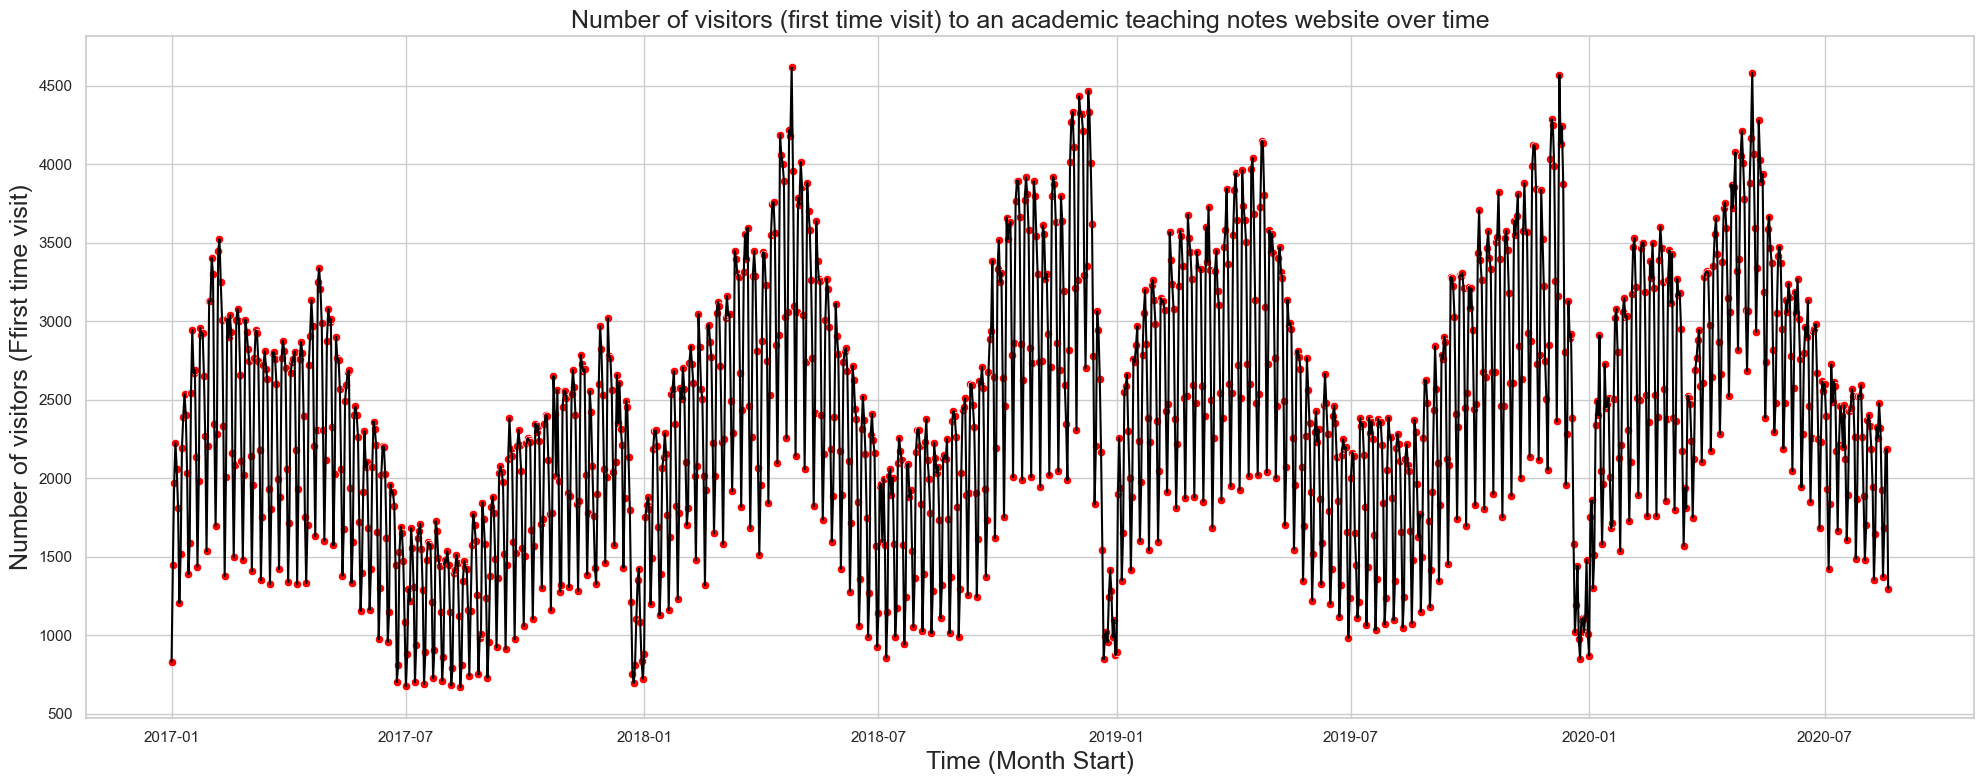

In [55]:
# Set the figure size
plt.figure(figsize=(20, 8))

###################################################################################
#plt.subplot(211)
sns.set(style="whitegrid")
sns.scatterplot(data=df, x="ds", y="y", color="red")
sns.lineplot(data=df, x="ds", y="y", color="black")
plt.xlabel('Time (Month Start)', fontsize=18)
plt.ylabel('Number of visitors (Ffirst time visit)', fontsize=18)
plt.title('Number of visitors (first time visit) to an academic teaching notes website over time', fontsize=18)

#plt.xlim([0, 36])
#plt.xticks(ticks=[0 + i*2 for i in range(19)])

#plt.ylim([0, 1])
#plt.yticks(ticks=[0 + i*0.05 for i in range(21)], labels=[f"{0 + i*5}%" for i in range(21)])

# Adjust layout
plt.tight_layout()

# Displaying the plots
plt.show()

Time series modeling typically uses in-time (training set) and out-of-time (test set) data for model training and testing to build a model. The parameters of the model is estimated using the in-time data and the model is then evaluated using the out-of-time data. Since the data has a time structure, we cannot randomly split the dataset. Instead, we define a cutoff date and set the data prior to the cutoff date as the in-time data (training set) and the data after the cutoff date as the out-of-time data (test set).
For the puporse of the exercise, **the cutoff date will be set to 2020–02–01**.


In [56]:
# Training data
tr_df = df[df['ds'] <= pd.to_datetime('2020-02-01')]

# Testing data
tt_df = df[df['ds']  > pd.to_datetime('2020-02-01')]

### 1.1.2. Step-by-Step Time Series Analysis

The standard steps in time series analysis involve identifying the trend, seasonal, and error components. While there are various methods to accomplish this, a simple approach is as follows:

- **Trend Identification:** Fit a linear model to the series to determine the trend, then remove the trend from the series.
- **Seasonal Component Identification:** Identify seasonal patterns by averaging the values for each month and/or week in the detrended series. Remove the seasonal component from the series afterward.
- **Residual Analysis:** Analyze the residuals, which represent what remains after removing the trend and seasonal components. Ideally, the residuals should follow a normal distribution with a mean of zero and exhibit no autocorrelation (commonly referred to as white noise).

Next, additional features are engineered to simplify and enhance the calculation of the trend and seasonal components.

In [90]:
# Creating a support dataframe for training
trts_df = (

    # Referencing the training data
    tr_df

    # Creating the columns: day of the week, month number and the x value (time indicator)
    .assign(
        weekday = lambda x: x.ds.dt.day_of_week,
        month = lambda x: x.ds.dt.month,
        x = lambda x: x.index + 1
    )

    # Creating higher order terms for x to facilitate fitting the model
    .assign(
        x2 = lambda x: x.x ** 2,
        x3 = lambda x: x.x ** 3
    )
)

# Printing first 3 rows
trts_df.head(3)

,y,ds,weekday,month,x,x2,x3
0,832,2017-01-01,6,1,1,1,1
1,1448,2017-01-02,0,1,2,4,8
2,1970,2017-01-03,1,1,3,9,27


In [91]:
# Creating a support dataframe for testing
ttts_df = (

    # Referencing the testing data
    tt_df

    # Creating the columns: day of the week, month number and the x value (time indicator)
    .assign(
        weekday = lambda x: x.ds.dt.day_of_week,
        month = lambda x: x.ds.dt.month,
        x = lambda x: x.index + 1
    )

    # Creating higher order terms for x to facilitate fitting the model
    .assign(
        x2 = lambda x: x.x ** 2,
        x3 = lambda x: x.x ** 3
    )
)

# Printing first 3 rows
ttts_df.head(3)

,y,ds,weekday,month,x,x2,x3
1127,2106,2020-02-02,6,2,1128,1272384,1435249152
1128,3174,2020-02-03,0,2,1129,1274641,1439069689
1129,3472,2020-02-04,1,2,1130,1276900,1442897000


#### 1.1.2.1. Removing Trend

Analyzing the results obtained from the linear models below, we observe that the first-order model produces the lowest error, as measured by the Root Mean Square Error (RMSE). Consequently, the detrending process is carried out using the first-order model. Detrending involves removing the trend (or level) from the y-values of the time series. This process results in a time series that ideally retains only the seasonal and error components.

Additionally, we observe that the coefficient of the first-order term in $x$ is positive, indicating a slight increase in the average number of first-time visitors to the website over time.

In [94]:
# Fitting a first order linear model to the training
lr_1o = LinearRegression(fit_intercept=True).fit(trts_df[['x']], trts_df['y'])

# Calculating the predictions for the first order linear model
y_pred_1o = lr_1o.predict(ttts_df[['x']])

# Calculating the root mean squared error for the first order linear model
rmse_1o = np.mean((y_pred_1o - ttts_df.y) ** 2 ) ** 0.5

# Printing the result
print(f"RMSE (1st order linear model): {rmse_1o}")
print(f"Linear Model Components: {lr_1o.coef_[0]:.2f} * x + {lr_1o.intercept_:.2f}")

RMSE (1st order linear model): 699.9060700214222
Linear Model Components: 0.60 * x + 1996.50


In [95]:
# Fitting a first order linear model to the training
lr_2o = LinearRegression(fit_intercept=True).fit(trts_df[['x', 'x2']], trts_df['y'])

# Calculating the predictions for the first order linear model
y_pred_2o = lr_2o.predict(ttts_df[['x', 'x2']])

# Calculating the root mean squared error for the first order linear model
rmse_2o = np.mean((y_pred_2o - ttts_df.y) ** 2 ) ** 0.5

# Printing the result
print(f"RMSE (2nd order linear model): {rmse_2o}")
print(f"Linear Model Components: {lr_2o.coef_[0]:.2f} * x + {lr_2o.coef_[1]:.2f} * x^2 + {lr_2o.intercept_:.2f}")

RMSE (2nd order linear model): 704.4604497937404
Linear Model Components: 1.02 * x + -0.00 * x^2 + 1916.62


In [96]:
# Fitting a first order linear model to the training
lr_3o = LinearRegression(fit_intercept=True).fit(trts_df[['x', 'x2', 'x3']], trts_df['y'])

# Calculating the predictions for the first order linear model
y_pred_3o = lr_3o.predict(ttts_df[['x', 'x2', 'x3']])

# Calculating the root mean squared error for the first order linear model
rmse_3o = np.mean((y_pred_3o - ttts_df.y) ** 2 ) ** 0.5

# Printing the result
print(f"RMSE (3rd order linear model): {rmse_3o}")
print(f"Linear Model Components: {lr_3o.coef_[0]:.2f} * x + {lr_3o.coef_[1]:.2f} * x^2 + {lr_3o.coef_[2]:.2f} * x^3 + {lr_3o.intercept_:.2f}")

RMSE (3rd order linear model): 1241.7199985267246
Linear Model Components: -3.05 * x + 0.01 * x^2 + -0.00 * x^3 + 2300.02


In [92]:
# Removing the trend from the training data
trts_df['y_detrended'] = trts_df['y'] - lr_1o.predict(trts_df[['x']])

# Removing the trend from the testing data
ttts_df['y_detrended'] = ttts_df['y'] - lr_1o.predict(ttts_df[['x']])

#### 1.1.2.2. Removing Seasonal Components

### 1.1.2. Fitting the data to a Prophet model

In [58]:
# Creating a Prophet model object
m = Prophet()

# Adding US holidays
m.add_country_holidays(country_name='US')

# Fit: Fitting with default parameters
m.fit(tr_df)

# Future: Generate data points for the future period
future= m.make_future_dataframe(periods=tt_df.shape[0], freq='d')

# Show the last 5 rows of the future dataframe                                
future.tail()

11:12:30 - cmdstanpy - INFO - Chain [1] start processing
11:12:30 - cmdstanpy - INFO - Chain [1] done processing


,ds
1322,2020-08-15
1323,2020-08-16
1324,2020-08-17
1325,2020-08-18
1326,2020-08-19


In [59]:
# Forecast: Apply the model to forecast the future data points
forecast=m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1322,2020-08-15,2520.448667,537.650929,1288.216588,2332.830389,2709.043356,0.0,0.0,0.0,0.0,...,-919.178791,-919.178791,-919.178791,-685.001872,-685.001872,-685.001872,0.0,0.0,0.0,916.268005
1323,2020-08-16,2520.360098,972.902962,1740.405816,2330.870631,2710.551328,0.0,0.0,0.0,0.0,...,-469.819035,-469.819035,-469.819035,-677.544571,-677.544571,-677.544571,0.0,0.0,0.0,1372.996491
1324,2020-08-17,2520.271528,1871.777199,2642.651419,2329.181963,2712.513285,0.0,0.0,0.0,0.0,...,425.117208,425.117208,425.117208,-670.074228,-670.074228,-670.074228,0.0,0.0,0.0,2275.314508
1325,2020-08-18,2520.182959,1948.917336,2727.079603,2327.493294,2714.475242,0.0,0.0,0.0,0.0,...,472.940813,472.940813,472.940813,-662.613406,-662.613406,-662.613406,0.0,0.0,0.0,2330.510366
1326,2020-08-19,2520.094389,1876.459308,2672.832457,2325.804625,2716.437199,0.0,0.0,0.0,0.0,...,435.699464,435.699464,435.699464,-655.154461,-655.154461,-655.154461,0.0,0.0,0.0,2300.639393


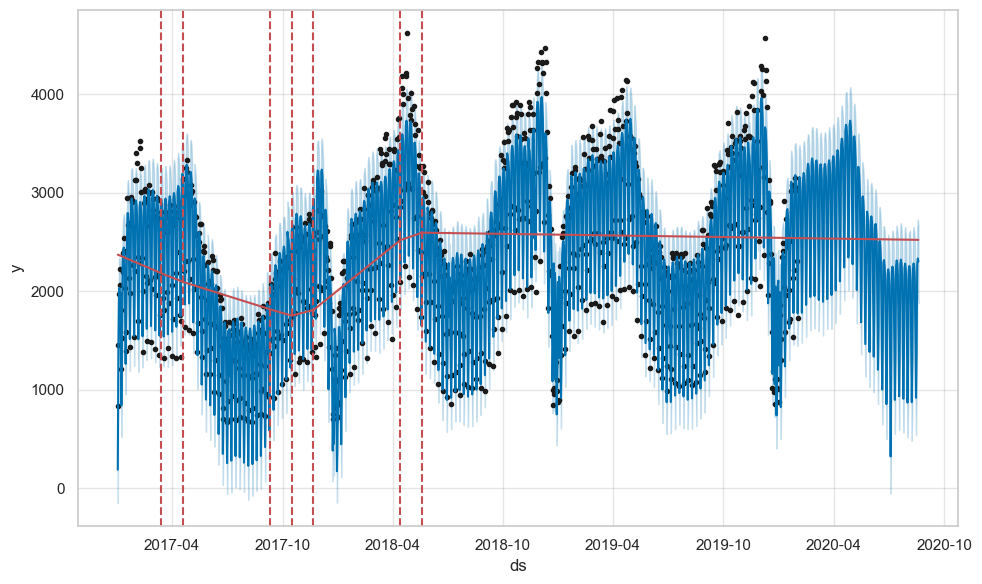

In [60]:
# Visualizong the forecast using the Prophet changepoints plot
# A change point in a time series refers to a point in time at which the statistical properties of the series, such as the mean, variance, or autocorrelation, change significantly.
fig= m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

Plotting model components:
- Trend;
- Holidays;
- Weekly seasonality;
- Yearly seasonality;

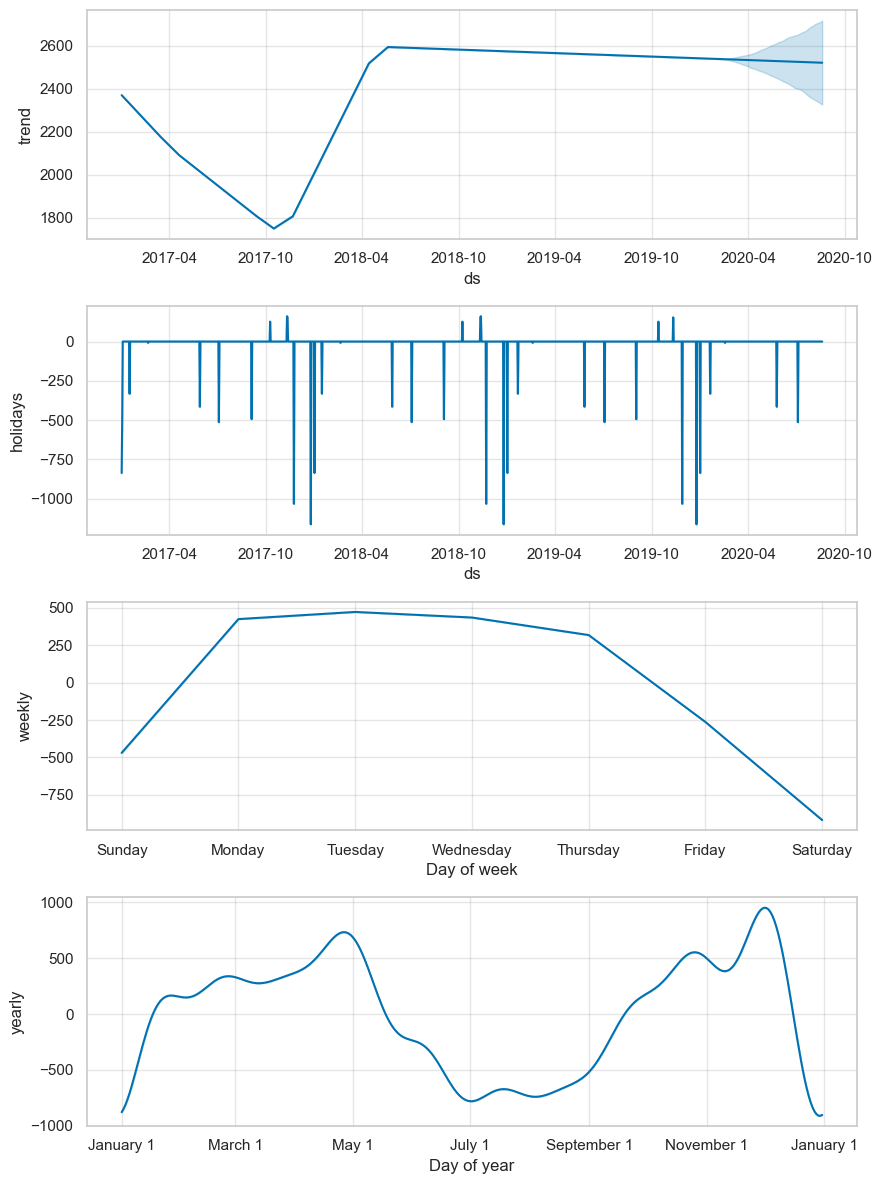

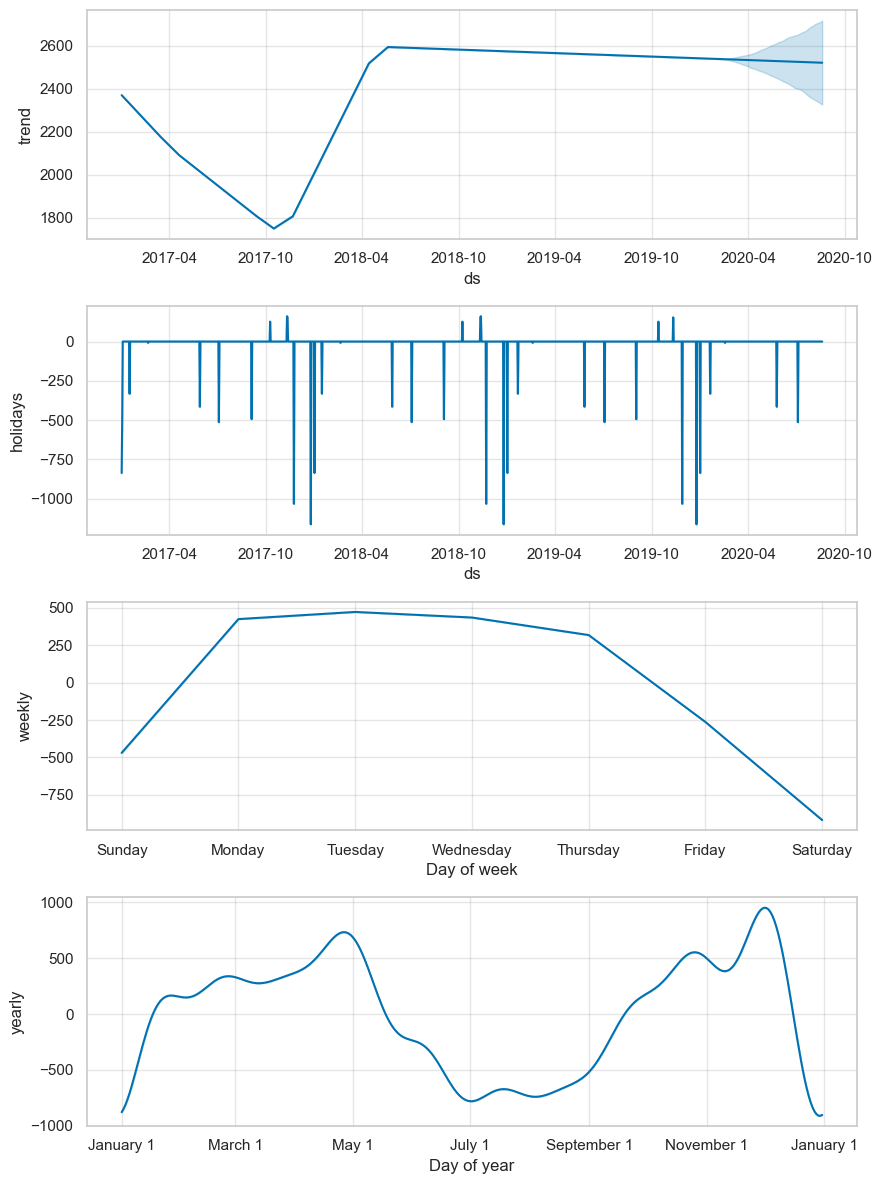

In [61]:
m.plot_components(forecast)